# <font color='red'> Laboratory #4: Adversarial Learning and OOD Detection

<font color='red'> In this laboratory session we will develop a methodology for detecting OOD samples and measuring the quality of OOD detection. We will also experiment with incorporating adversarial examples during training to render models more robust to adversarial attacks.

---

In [121]:
# Import
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.datasets import CIFAR10, CIFAR100
import torchvision.transforms as transforms

from sklearn.metrics import (
    RocCurveDisplay,
    PrecisionRecallDisplay,
    precision_recall_curve,
    roc_auc_score,
    accuracy_score,
    confusion_matrix,
    classification_report,
    auc
)

import optuna

from tqdm.auto import tqdm

In [4]:
# Variabili globali da usare per tutto il notebook
device = 'cuda' if torch.cuda.is_available() else 'cpu'
criterion = nn.CrossEntropyLoss()

## <font color='red'> Exercise 1: OOD Detection and Performance Evaluation
<font color='red'>In this first exercise you will build a simple OOD detection pipeline and implement some performance metrics to evaluate its performance.

### <font color='red'>Exercise 1.1: Build a simple OOD detection pipeline

<font color='red'>Implement an OOD detection pipeline (like in the Flipped Activity notebook) using an ID and an OOD dataset of your choice. Some options:

+ <font color='red'>CIFAR-10 (ID), Subset of CIFAR-100 (OOD). You will need to wrap CIFAR-100 in some way to select a subset of classes that are *not* in CIFAR-10 (see `torch.utils.data.Subset`).
+ <font color='red'>Labeled Faces in the Wild (ID), CIFAR-10 or FakeData (OOD). The LfW dataset is available in Scikit-learn (see `sklearn.datasets.fetch_lfw_people`).
+ <font color='red'>Something else, but if using images keep the images reasonably small!

<font color='red'>In this exercise your *OOD Detector* should produce a score representing how "out of distribution" a test sample is. We will implement some metrics in the next exercise, but for now use the techniques from the flipped activity notebook to judge how well OOD scoring is working (i.e. histograms).

<font color='red'> **Note**: Make sure you make a validation split of your ID dataset for testing.

### Dataset

In [5]:
# Variabili per i dataset
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
batch_size = 32

# Dataset
# CIFAR10 (in distribution dataset)
ds_train = CIFAR10(root='./data', train=True, download=True, transform=transform)
dl_train = torch.utils.data.DataLoader(ds_train, batch_size=batch_size, shuffle=True, num_workers=2)

ds_ID = CIFAR10(root='./data', train=False, download=True, transform=transform)
dl_ID = torch.utils.data.DataLoader(ds_ID, batch_size=batch_size, shuffle=False, num_workers=2)

# CIFAR100 (out of distribution dataset)
ds_OOD = CIFAR100(root='./data', train=False, download=True, transform=transform)
dl_OOD = torch.utils.data.DataLoader(ds_OOD, batch_size=batch_size, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


### Training

In [6]:
# Funzioni per il training
def train(x_train, y_train, model, criterion, optimizer, device):
    x_train = x_train.to(device)
    y_train = y_train.to(device)

    y_pred = model(x_train)
    loss = criterion(y_pred, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()

def run_train(dl_train, model, criterion, optimizer, device, epochs):
    for epoch in range(epochs):
        train_loss = list()
        model.train()
        for (x_train, y_train) in dl_train:
            train_loss.append(train(x_train, y_train, model, criterion, optimizer, device))
        
        print(
            f"Epoch={epoch} | Train_Loss={np.mean(train_loss):.3f}"
        )

    print('Finished Training')
    torch.save(model.state_dict(), './CNN.pth')

### Testing & Logits

In [7]:
def accuracy(y_true, y_pred):
    y_pred = y_pred.cpu().detach().numpy()
    y_pred = np.argmax(y_pred, axis=1)
    y_true = y_true.cpu().detach().numpy()
    return accuracy_score(y_true, y_pred)

def test(dl_test, model, criterion, device):
    model.eval()
    test_accuracy = list()
    for (x_test, y_test) in dl_test:

        x_test = x_test.to(device)
        y_test = y_test.to(device)
        
        with torch.no_grad():
            y_pred = model(x_test)
            loss = criterion(y_pred, y_test)
        
        test_accuracy.append(accuracy(y_test, y_pred))

    mean_test_acc = np.mean(test_accuracy)
    return mean_test_acc

def run_test(dl_test, model, criterion, device):
    
    test_acc = test(dl_test, model, criterion, device)
    
    return test_acc

In [8]:
# Funzione per collezionare i logits.
# (Nota: questa funzione è ispirata a quella della lezione flipped,
# ma è stata modificata in modo che il risultato sia un tensore torch)

def collect_logits(model, dl):
    logits = list()
    with torch.no_grad():
        for (x, _) in dl:
            logits.append(model(x.to(device)).cpu())
    return torch.cat(logits, dim=0)

### Model Definition

In [9]:
# Definizione del modello utilizzato
# (nota: la CNN utilizzata è la stessa CNN definita nella lezione flipped)
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### Model Loading / Training

In [10]:
# Carica il modello da file
model = CNN().to(device)
model.load_state_dict(torch.load('./CNN.pth'))

<All keys matched successfully>

In [ ]:
# Train del modello
epochs = 50
optimizer = optim.Adam(model.parameters(), lr=0.001)

model = CNN().to(device)
run_train(dl_train, model, criterion, optimizer, device, epochs)

### OOD Detectors

Si è deciso di usare due tipi diversi di metriche per l'OOD Detector.
- Come prima metrica si è scelto di osservare la varianza dei logits: più è bassa la varianza, più è bassa la probabilità che l'immagine appartenga alla distribuzione.
- Come seconda metrica si è scelto di osservare il valore massimo della probabilità delle classi: più è bassa la probabilità massima, più è bassa la probabilità che l'immagine appartenga alla distribuzione.

In [12]:
#OOD Detectors
def ood_var_score(logits):
    return logits.var(dim=1)

def ood_prob_score(logits):
    prob = torch.softmax(logits, dim=1)
    return prob.max(dim=1).values

In [13]:
# Calcola i logits
logits_ID = collect_logits(model, dl_ID)
logits_OOD = collect_logits(model, dl_OOD)

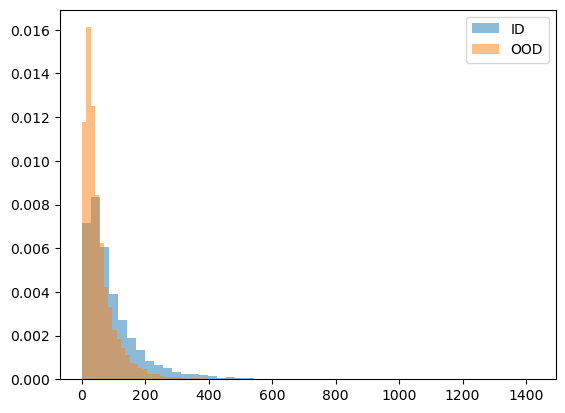

In [14]:
# Istogramma basato sulla varianza
_ = plt.hist(ood_var_score(logits_ID), 50, density=True, alpha=0.5, label='ID')
_ = plt.hist(ood_var_score(logits_OOD), 50, density=True, alpha=0.5, label='OOD')
plt.legend()

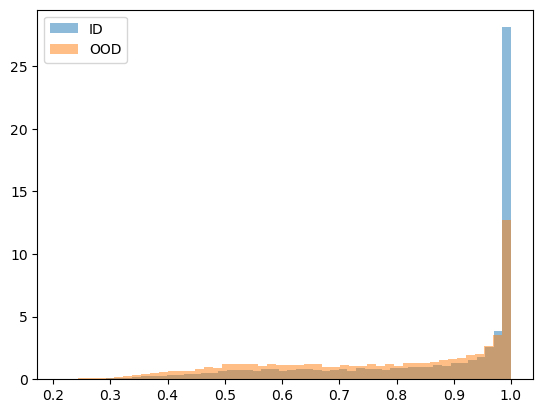

In [12]:
# Istogramma basato sulla probabilità
_ = plt.hist(ood_prob_score(logits_ID), 50, density=True, alpha=0.5, label='ID')
_ = plt.hist(ood_prob_score(logits_OOD), 50, density=True, alpha=0.5, label='OOD')
plt.legend()

Come si può notare, in entrambi i casi c'è una grande sovrapposizione tra gli elementi in distribution e quelli out of distribution. Di conseguenza il modello è facilmente attaccabile da adversarial attacks.

### <font color='red'>Exercise 1.2: Measure your OOD detection performance

<font color='red'>There are several metrics used to evaluate OOD detection performance, we will concentrate on two threshold-free approaches: the area under the Receiver Operator Characteristic (ROC) curve for ID classification, and the area under the Precision-Recall curve for *both* ID and OOD scoring. See [the ODIN paper](https://arxiv.org/pdf/1706.02690.pdf) section 4.3 for a description of OOD metrics.

<font color='red'>Use the functions in `sklearn.metrics` to produce ROC and PR curves for your OOD detector. Some useful functions:

+ <font color='red'>[`sklearn.metric.RocCurveDisplay.from_predictions`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.RocCurveDisplay.html)
+ <font color='red'>[`sklearn.metrics.PrecisionRecallDisplay`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.PrecisionRecallDisplay.html)


In [15]:
# Labels
labels_ID = np.array([False for _ in range(len(logits_ID))])
labels_OOD = np.array([True for _ in range(len(logits_OOD))])
labels = np.concatenate([labels_ID, labels_OOD])

# Predizioni per l'ood detector basato sulla varianza
score_var_ID = ood_var_score(logits_ID)
score_var_OOD = ood_var_score(logits_OOD)
score_var = np.concatenate([score_var_ID, score_var_OOD])

# Predizioni per l'ood detector basato sulla probabilità
score_prob_ID = ood_prob_score(logits_ID)
score_prob_OOD = ood_prob_score(logits_OOD)
score_prob = np.concatenate([score_prob_ID, score_prob_OOD])

# Predizioni nel caso in cui si tiri a caso
score_random = np.random.choice(2, size=labels.shape).astype(bool)

Di seguito vengono riportati la AUROC e la AUPRC per entrambi i tipi di detector.

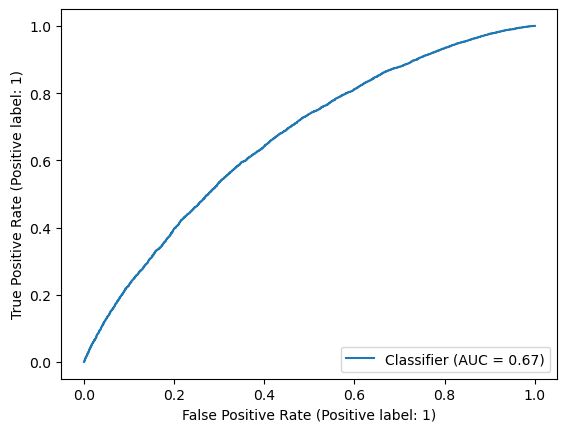

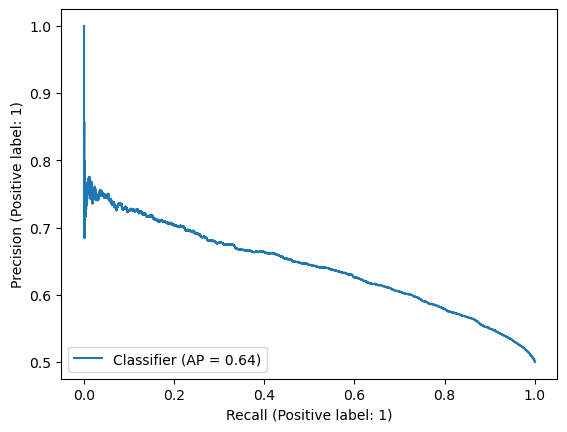

In [16]:
#Nota: si deve mettere -score perché più lo score è alto, e più è probabile che sia ID (label = False)
svc_disp = RocCurveDisplay.from_predictions(labels, -score_var)
svc_disp = PrecisionRecallDisplay.from_predictions(labels, -score_var)

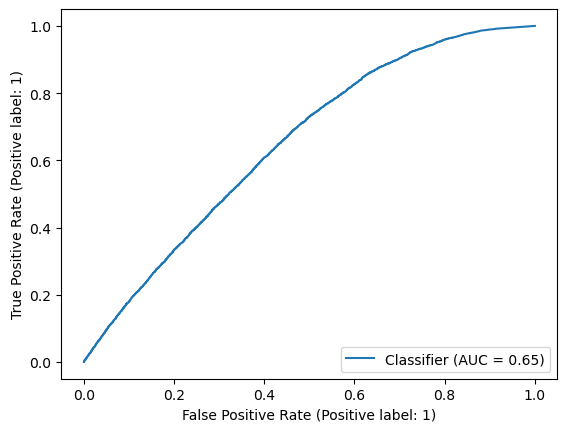

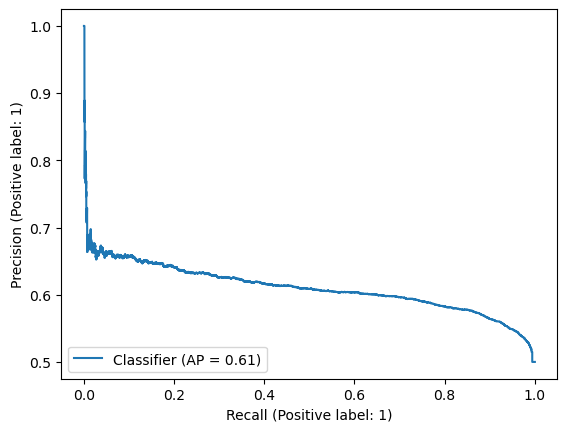

In [17]:
#Nota: si deve mettere -score perché più lo score è alto, e più è probabile che sia ID (label = False)
svc_disp = RocCurveDisplay.from_predictions(labels, -score_prob)
svc_disp = PrecisionRecallDisplay.from_predictions(labels, -score_prob)

Osservando queste metriche, si osserva che l'idea di utilizzare la varianza dei logits per discriminare tra ID e OOD sia leggermente migliore di quella di usare il massimo delle probabilità. Inoltre, si nota che il nostro Detector ha comunque una averange precision > 0.5 (quindi è comunque più bravo del tirare completamente a caso)

---
## <font color='red'>Exercise 2: Enhancing Robustness to Adversarial Attack

<font color='red'>In this second exercise we will experiment with enhancing our base model to be (more) robust to adversarial attacks. 

### <font color='red'>Exercise 2.1: Implement FGSM and generate adversarial examples

<font color='red'>Recall that the Fast Gradient Sign Method (FGSM) perturbs samples in the direction of the gradient with respect to the input $\mathbf{x}$:
$$ \boldsymbol{\eta}(\mathbf{x}) = \varepsilon \mathrm{sign}(\nabla_{\mathbf{x}} \mathcal{L}(\boldsymbol{\theta}, \mathbf{x}, y)) ) $$
<font color='red'>Implement FGSM and generate some *adversarial examples* using your trained ID model. Evaluate these samples qualitatively and quantitatively. Evaluate how dependent on $\varepsilon$ the quality of these samples are. 

### FGSM

In [18]:
# Funzioni che implementano FGSM e che generano un dataset di adversarial examples utilizzando FGSM

def fgsm(image, eps, image_grad):
    return torch.clamp(image + eps*image_grad.sign(), -1, 1)

def generate_adversarial_batch(X, Y, eps, model, criterion, device):
    X = X.to(device)
    Y = Y.to(device)

    X.requires_grad = True

    Y_pred = model(X)
    loss = criterion(Y_pred, Y)

    model.zero_grad()
    loss.backward()

    X_grad = X.grad
    
    adv_X = fgsm(X, eps, X_grad).detach().cpu()
    adv_Y = Y.cpu()
    
    return adv_X, adv_Y

def generate_adversarial_dataset(dl, eps, model, criterion, device):
    adv_Xs = list()
    adv_Ys = list()
    
    for (X, Y) in dl:
        adv_X, adv_Y = generate_adversarial_batch(X, Y, eps, model, criterion, device)
        adv_Xs.append(adv_X)
        adv_Ys.append(adv_Y)
        
    tensor_Xs = torch.cat(adv_Xs, dim=0)
    tensor_Ys = torch.cat(adv_Ys, dim=0)
    
    return torch.utils.data.TensorDataset(tensor_Xs, tensor_Ys)

### Experiments (Part I - OOD Detector)

In questa prima parte degli esperimenti si osserva come cambia il comportamento dell'OOD Detector a seconda dell'aumentare/diminuire di epsilon. Iniziamo con epsilon = 0.1

In [19]:
# Dataset e Dataloader con adversarial examples generati tramite FGSM

ds_fgsm_1 = generate_adversarial_dataset(dl_ID, 0.1, model, criterion, device)
dl_fgsm_1 = torch.utils.data.DataLoader(ds_fgsm_1, batch_size=batch_size, shuffle=False, num_workers=2)

In [20]:
# Calcolo dei logits sul modello addestrato nell'esercizio precedente con il dataset FGSM

logits_fgsm_1 = collect_logits(model, dl_fgsm_1)

In [21]:
labels_ID = np.array([True for _ in range(len(logits_ID))])
labels_fgsm_1 = np.array([False for _ in range(len(logits_fgsm_1))])
labels1 = np.concatenate([labels_ID, labels_fgsm_1])

scores_ID = ood_var_score(logits_ID)
scores_fgsm_1 = ood_var_score(logits_fgsm_1)
scores1 = np.concatenate([scores_ID, scores_fgsm_1])

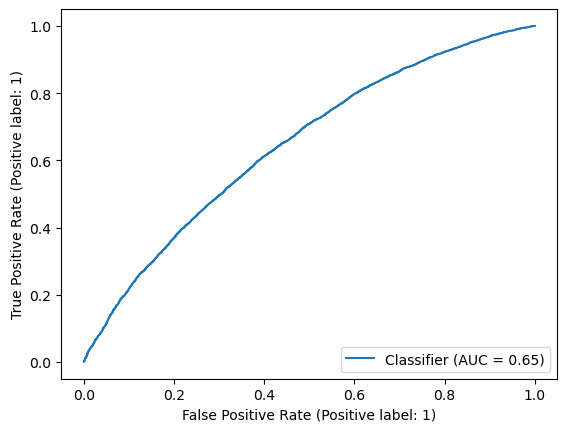

In [22]:
svc_disp = RocCurveDisplay.from_predictions(labels1, -scores1)

E adesso diminuiamo epsilon:

In [23]:
# Dataset e Dataloader con adversarial examples generati tramite FGSM

ds_fgsm_2 = generate_adversarial_dataset(dl_ID, 0.01, model, criterion, device)
dl_fgsm_2 = torch.utils.data.DataLoader(ds_fgsm_2, batch_size=batch_size, shuffle=False, num_workers=2)

ds_fgsm_3 = generate_adversarial_dataset(dl_ID, 0.001, model, criterion, device)
dl_fgsm_3 = torch.utils.data.DataLoader(ds_fgsm_3, batch_size=batch_size, shuffle=False, num_workers=2)

ds_fgsm_4 = generate_adversarial_dataset(dl_ID, 0.0001, model, criterion, device)
dl_fgsm_4 = torch.utils.data.DataLoader(ds_fgsm_4, batch_size=batch_size, shuffle=False, num_workers=2)

In [24]:
# Calcolo dei logits sul modello addestrato nell'esercizio precedente con il dataset FGSM

logits_fgsm_2 = collect_logits(model, dl_fgsm_2)
logits_fgsm_3 = collect_logits(model, dl_fgsm_3)
logits_fgsm_4 = collect_logits(model, dl_fgsm_4)

In [25]:
labels_fgsm_2 = np.array([False for _ in range(len(logits_fgsm_2))])
labels2 = np.concatenate([labels_ID, labels_fgsm_2])

scores_fgsm_2 = ood_var_score(logits_fgsm_2)
scores2 = np.concatenate([scores_ID, scores_fgsm_2])


labels_fgsm_3 = np.array([False for _ in range(len(logits_fgsm_3))])
labels3 = np.concatenate([labels_ID, labels_fgsm_3])

scores_fgsm_3 = ood_var_score(logits_fgsm_3)
scores3 = np.concatenate([scores_ID, scores_fgsm_3])


labels_fgsm_4 = np.array([False for _ in range(len(logits_fgsm_4))])
labels4 = np.concatenate([labels_ID, labels_fgsm_4])

scores_fgsm_4 = ood_var_score(logits_fgsm_4)
scores4 = np.concatenate([scores_ID, scores_fgsm_4])

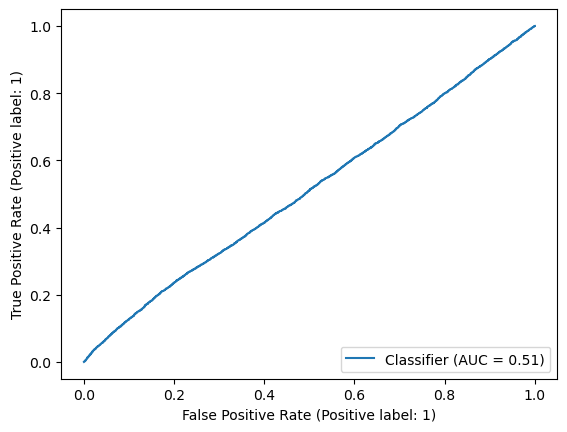

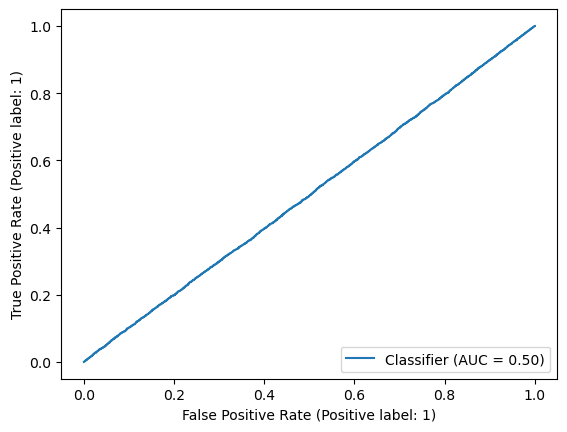

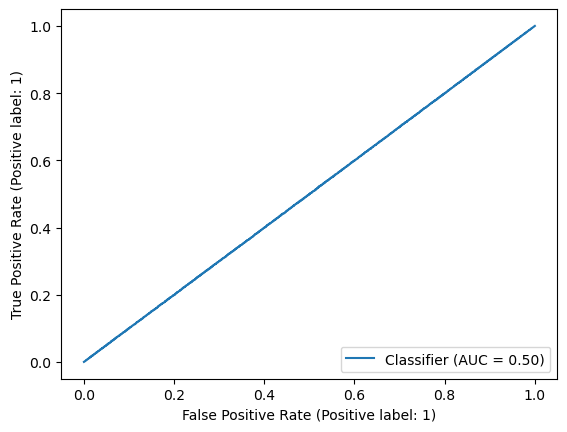

In [26]:
svc_disp = RocCurveDisplay.from_predictions(labels2, -scores2)
svc_disp = RocCurveDisplay.from_predictions(labels3, -scores3)
svc_disp = RocCurveDisplay.from_predictions(labels4, -scores4)

Si può osservare che diminuendo epsilon il detector diventa meno accurato: di conseguenza più epsilon è minore più le adversarial images si confondono con le immagini di partenza.

Per controriprova, proviamo a mettere un epsilon maggiore di 0.1:

In [27]:
# Dataset e Dataloader con adversarial examples generati tramite FGSM

ds_fgsm_5 = generate_adversarial_dataset(dl_ID, 0.5, model, criterion, device)
dl_fgsm_5 = torch.utils.data.DataLoader(ds_fgsm_5, batch_size=batch_size, shuffle=False, num_workers=2)

In [28]:
# Calcolo dei logits sul modello addestrato nell'esercizio precedente con il dataset FGSM

logits_fgsm_5 = collect_logits(model, dl_fgsm_5)

In [29]:
labels_fgsm_5 = np.array([False for _ in range(len(logits_fgsm_5))])
labels5 = np.concatenate([labels_ID, labels_fgsm_5])

scores_fgsm_5 = ood_var_score(logits_fgsm_5)
scores5 = np.concatenate([scores_ID, scores_fgsm_5])

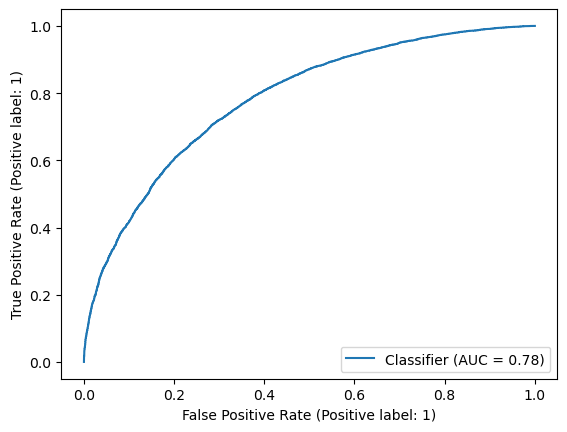

In [30]:
svc_disp = RocCurveDisplay.from_predictions(labels5, -scores5)

----
### Experiments (Part II - Model accuracy)
Abbiamo visto che più l'epsilon è piccolo, più diventa difficile per il Detector capire se un'immagine è stata perturbata o meno. In questa sezione, si vuole osservare come però perturbazioni troppo piccole (con epsilon troppo piccolo) comportano anche un attacco avversario poco efficace. Infatti, se andiamo a testare il modello sui dataset generati attraverso le immagini perturbate:

In [33]:
#Accuracy del modello con i dataset perturbati
acc_ID = run_test(dl_ID, model, criterion, device)
acc_fgsm_1 = run_test(dl_fgsm_1, model, criterion, device)
acc_fgsm_2 = run_test(dl_fgsm_2, model, criterion, device)
acc_fgsm_3 = run_test(dl_fgsm_3, model, criterion, device)
acc_fgsm_4 = run_test(dl_fgsm_4, model, criterion, device)
acc_fgsm_5 = run_test(dl_fgsm_5, model, criterion, device)

print(f"Accuracy | dataset di partenza: {acc_ID:.2f}")
print(f"Accuracy | eps 0.5: {acc_fgsm_5:.2f}")
print(f"Accuracy | eps 0.1: {acc_fgsm_1:.2f}")
print(f"Accuracy | eps 0.01: {acc_fgsm_2:.2f}")
print(f"Accuracy | eps 0.001: {acc_fgsm_3:.2f}")
print(f"Accuracy | eps 0.0001: {acc_fgsm_4:.2f}")

Accuracy | dataset di partenza: 0.61
Accuracy | eps 0.5: 0.08
Accuracy | eps 0.1: 0.05
Accuracy | eps 0.01: 0.26
Accuracy | eps 0.001: 0.55
Accuracy | eps 0.0001: 0.60


Come si può notare, epsilon molto piccoli comportano così poche perturbazioni da non rendere le immagini perturbate degli attacchi efficaci contro la rete. Di conseguenza, si deve scegliere l'epsilon giusto per fare in modo che le immagini generate siano non riconosciute come OOD dal Detector e, allo stesso tempo, abbassino l'accuracy del modello.

Tra gli epsilon scelti, il migliore sembra essere quello con epsilon = 0.01

----

### Experiments (Part III - Images)

Infine, osserviamo cosa succede a un'immagine con le diverse perturbazioni:

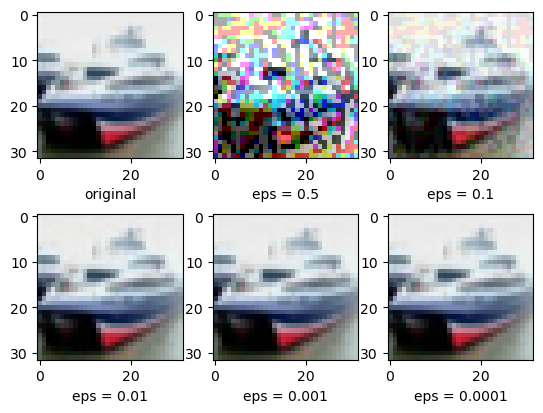

In [34]:
def norm_image(x):
    return ((x+1)/2).permute(1, 2, 0)

x_ID, _ = ds_ID[1]
plt.subplot(2, 3, 1)
plt.imshow(norm_image(x_ID))
plt.xlabel('original')

x_fgsm_5, _ = ds_fgsm_5[1]
plt.subplot(2, 3, 2)
plt.imshow(norm_image(x_fgsm_5))
plt.xlabel('eps = 0.5')

x_fgsm_1, _ = ds_fgsm_1[1]
plt.subplot(2, 3, 3)
plt.imshow(norm_image(x_fgsm_1))
plt.xlabel('eps = 0.1')

x_fgsm_2, _ = ds_fgsm_2[1]
plt.subplot(2, 3, 4)
plt.imshow(norm_image(x_fgsm_2))
plt.xlabel('eps = 0.01')

x_fgsm_3, _ = ds_fgsm_3[1]
plt.subplot(2, 3, 5)
plt.imshow(norm_image(x_fgsm_3))
plt.xlabel('eps = 0.001')

x_fgsm_4, _ = ds_fgsm_4[1]
plt.subplot(2, 3, 6)
plt.imshow(norm_image(x_fgsm_4))
_ = plt.xlabel('eps = 0.0001')

Come si può notare, più è grande l'epsilon più l'immagine diventa irriconoscibile anche a occhio nudo.

Questo esperimento conferma che l'epsilon migliore per compiere un attacco è probabilmente 0.01, perché:
- l'immagine originale e quella perturbata sono identiche a occhio nudo
- il dataset perturbato abbassa molto l'accuracy del modello (da un'accuracy del 61% a una del 25%)
- il dataset perturbato non viene riconosciuto come OOD dal Detector (AUC di solo 0.51)

### <font color='red'> Exercise 2.2: Augment training with adversarial examples

<font color='red'>Use your implementation of FGSM to augment your training dataset with adversarial samples. Ideally, you should implement this data augmentation *on the fly* so that the adversarial samples are always generated using the current model. Evaluate whether the model is more (or less) robust to ID samples using your OOD detection pipeline and metrics you implemented in Exercise 1.

### Training Routine

In [55]:
# Funzione per il robust-training

def run_robust_train(dl_train, eps, model, criterion, optimizer, device, epochs):
    model.train()
    for epoch in range(epochs):
        train_loss = list()
        
        for (x_train, y_train) in dl_train:
            train_loss.append(train(x_train, y_train, model, criterion, optimizer, device))
            # Si generano i dati adversarial per ogni batch in ogni epoca per fare un training più robusto
            x_fgsm, y_fgsm = generate_adversarial_batch(x_train, y_train, eps, model, criterion, device)
            train_loss.append(train(x_fgsm, y_fgsm, model, criterion, optimizer, device))
            
        print(f"Epoch={epoch} | Train_Loss={np.mean(train_loss):.3f}")

    print('Finished Training')

### Model

In [57]:
# Modello
robust_model = CNN().to(device)

# Training hyperparameters
epochs = 20
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(robust_model.parameters(), lr=0.001)
epsilon = 0.001

# Train model
run_robust_train(dl_train, epsilon, robust_model, criterion, optimizer, device, epochs)

Epoch=0 | Train_Loss=1.520
Epoch=1 | Train_Loss=1.228
Epoch=2 | Train_Loss=1.123
Epoch=3 | Train_Loss=1.051
Epoch=4 | Train_Loss=0.996
Epoch=5 | Train_Loss=0.955
Epoch=6 | Train_Loss=0.917
Epoch=7 | Train_Loss=0.887
Epoch=8 | Train_Loss=0.853
Epoch=9 | Train_Loss=0.828
Epoch=10 | Train_Loss=0.806
Epoch=11 | Train_Loss=0.786
Epoch=12 | Train_Loss=0.767
Epoch=13 | Train_Loss=0.748
Epoch=14 | Train_Loss=0.728
Epoch=15 | Train_Loss=0.710
Epoch=16 | Train_Loss=0.698
Epoch=17 | Train_Loss=0.678
Epoch=18 | Train_Loss=0.671
Epoch=19 | Train_Loss=0.656
Finished Training


### Experiments

In [105]:
# Colleziona i logits

r_logits_ID = collect_logits(robust_model, dl_ID)
r_logits_fgsm = collect_logits(robust_model, dl_fgsm_1)

In [102]:
r_labels_ID = np.array([True for _ in range(len(r_logits_ID))])
r_labels_fgsm = np.array([False for _ in range(len(r_logits_fgsm))])
r_labels = np.concatenate([r_labels_ID, r_labels_fgsm])

r_scores_ID = ood_var_score(r_logits_ID)
r_scores_fgsm = ood_var_score(r_logits_fgsm)
r_scores = np.concatenate([r_scores_ID, r_scores_fgsm])

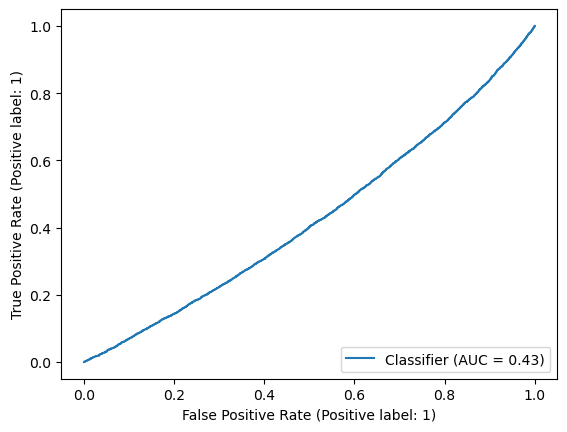

In [103]:
svc_disp = RocCurveDisplay.from_predictions(r_labels, -r_scores)

Come si può osservare dalla curva, il nostro OOD detector fa più fatica a distinguere le immagini appartenenti alla distribuzione originale da quelle perturbate.

Questo però è un buon segno: significa che il modello è diventato più robusto alle immagini perturbate e riesce a prevedere la giusta label anche nel caso in cui l'immagine sia stata perturbata. Questo può essere provato andando a confrontare l'accuracy del modello iniziale e di quello robusto se si danno in ingresso delle immagini perturbate. Infatti:

In [119]:
#Accuracy dei modelli con il dataset perturbato
acc_fgsm_model = run_test(dl_fgsm_1, model, criterion, device)
acc_fgsm_robust = run_test(dl_fgsm_1, robust_model, criterion, device)
print(f"Accuracy modello non robusto: {acc_fgsm_model:.2f}")
print(f"Accuracy modello robusto: {acc_fgsm_robust:.2f}")

Accuracy modello non robusto: 0.05
Accuracy modello robusto: 0.47


Infine, si noti come il modello non perde la sua accuracy anche per quanto riguarda il dataset non perturbato:

In [121]:
#Accuracy dei modelli con il dataset iniziale
acc_ID_model = run_test(dl_ID, model, criterion, device)
acc_ID_robust = run_test(dl_ID, robust_model, criterion, device)
print(f"Accuracy modello non robusto: {acc_ID_model:.2f}")
print(f"Accuracy modello robusto: {acc_ID_robust:.2f}")

Accuracy modello non robusto: 0.61
Accuracy modello robusto: 0.62


---
## <font color='red'>Exercise 3: Wildcard

<font color='red'>You know the drill. Pick *ONE* of the following exercises to complete.

### <font color='red'>Exercise 3.1: Implement ODIN for OOD detection
<font color='red'>ODIN is a very simple approach, and you can already start experimenting by implementing a temperature hyperparameter in your base model and doing a grid search on $T$ and $\varepsilon$.


### ODIN Implementation

In [35]:
#ODIN input preprocessing

def generate_odin_dataset(dl, eps, T, model):
    model.eval()
    adv_Xs = list()
    adv_Ys = list()
        
    for (X, Y) in dl:
        X = X.to(device)
        
        X.requires_grad = True
        
        logits = model(X)
        max_index = torch.max(logits, dim=1).indices #Calcola la label predetta dal modello
        
        loss = criterion(logits/T, max_index)
        loss.backward()
        
        adv_Xs.append(fgsm(X, eps, X.grad).detach().cpu()) #Equivale alla perturbazione nel paper di ODIN
        adv_Ys.append(Y)
        
    tensor_Xs = torch.cat(adv_Xs, dim=0)
    tensor_Ys = torch.cat(adv_Ys, dim=0)
    
    return torch.utils.data.TensorDataset(tensor_Xs, tensor_Ys)

def odin_input_preprocessing(dl, eps, model, T):
    ds_odin = generate_odin_dataset(dl, eps, T, model) #Usa fgsm per perturbare gli input
    return torch.utils.data.DataLoader(ds_odin, batch_size=batch_size, shuffle=False, num_workers=2)

In [110]:
#ODIN model

def odin_score(model, T, eps, dl):
    dl_odin = odin_input_preprocessing(dl, eps, model, T) #Fa la perturbazione degli input
    logits = collect_logits(model, dl_odin) #Calcola i logits
    prob = torch.softmax(logits/T, dim=1) #Calcola la softmax con temperatura
    softmax_score = torch.max(prob, dim=1).values #Restituisce la probabilità maggiore
    return softmax_score.numpy()

def calculate_odin_threshold(softmax_score, labels):
    _, recall, thresholds = precision_recall_curve(labels, softmax_score)
    return thresholds[np.argmin(recall > 0.95)]

def odin_detector(softmax_score, threshold):
    return softmax_score > threshold #True se è in distribution, False se è out of distribution

**Attenzione:** a differenza degli altri esercizi, in questo caso i positivi sono gli in distribution e i negativi gli out of distribution, coerentemente con quanto scritto nell'articolo.

### Hyperparameters Optimization

Per trovare il migliore valore per la temperatura e per epsilon, si è inizialmente svolta una grid search.

Come obiettivo si è deciso di massimizzare la AUROC, perché è la metrica che è stata utilizzata e osservata negli altri esperimenti del notebook.

In [126]:
#Grid-search di temperature (T) e epsilon (eps)

labels_ID = np.array([True for _ in range(len(ds_ID))])
labels_OOD = np.array([False for _ in range(len(ds_OOD))])
labels = np.concatenate([labels_ID, labels_OOD])

best_roc = -np.inf
best_params = None

for T in np.linspace(1, 10000, 5):
    for eps in np.linspace(0.0001, 0.001, 5):
        scores_ID = odin_score(model, T, eps, dl_ID)
        scores_OOD = odin_score(model, T, eps, dl_OOD)
        scores = np.concatenate([scores_ID, scores_OOD])
        
        roc = roc_auc_score(labels, scores)
        
        if roc > best_roc:
            best_roc = roc
            best_params = [T, eps]
            print(f'T: {T:.1f} | eps: {eps:.4f} | roc: {roc:.3f} (*)')
        else:
            print(f'T: {T:.1f} | eps: {eps:.4f} | roc: {roc:.3f}')

T: 1.0 | eps: 0.0001 | roc: 0.651 (*)
T: 1.0 | eps: 0.0003 | roc: 0.650
T: 1.0 | eps: 0.0006 | roc: 0.651 (*)
T: 1.0 | eps: 0.0008 | roc: 0.652 (*)
T: 1.0 | eps: 0.0010 | roc: 0.652 (*)
T: 2500.8 | eps: 0.0001 | roc: 0.688 (*)
T: 2500.8 | eps: 0.0003 | roc: 0.688
T: 2500.8 | eps: 0.0006 | roc: 0.688
T: 2500.8 | eps: 0.0008 | roc: 0.687
T: 2500.8 | eps: 0.0010 | roc: 0.687
T: 5000.5 | eps: 0.0001 | roc: 0.688
T: 5000.5 | eps: 0.0003 | roc: 0.688
T: 5000.5 | eps: 0.0006 | roc: 0.687
T: 5000.5 | eps: 0.0008 | roc: 0.687
T: 5000.5 | eps: 0.0010 | roc: 0.687
T: 7500.2 | eps: 0.0001 | roc: 0.688
T: 7500.2 | eps: 0.0003 | roc: 0.688
T: 7500.2 | eps: 0.0006 | roc: 0.687
T: 7500.2 | eps: 0.0008 | roc: 0.687
T: 7500.2 | eps: 0.0010 | roc: 0.687
T: 10000.0 | eps: 0.0001 | roc: 0.688
T: 10000.0 | eps: 0.0003 | roc: 0.688
T: 10000.0 | eps: 0.0006 | roc: 0.687
T: 10000.0 | eps: 0.0008 | roc: 0.687
T: 10000.0 | eps: 0.0010 | roc: 0.687


Dopo diversi esperimenti utilizzando la grid-search, si è deciso di cambiare approccio e di utilizzare optuna per la ricerca degli iperparametri, in quanto permette di fare una ricerca con degli intervalli più ampi in decisamente meno tempo della grid-search

In [100]:
class Objective:
    def __init__(self, model, dl_ID, dl_OOD, labels, log):
        self.model = model
        self.dl_ID = dl_ID
        self.dl_OOD = dl_OOD
        self.labels = labels
    
    def __call__(self, trial):
        T = trial.suggest_float('T', 0.1, 10000, log=True)
        eps = trial.suggest_float('eps', 1e-5, 1, log=True)
        
        scores_ID = odin_score(self.model, T, eps, self.dl_ID)
        scores_OOD = odin_score(self.model, T, eps, self.dl_OOD)
        scores = np.concatenate([scores_ID, scores_OOD])
        
        roc = roc_auc_score(labels, scores)
        
        return roc

In [103]:
study = optuna.create_study(
    storage="sqlite:///study.db",
    study_name="study_odin",
    sampler=optuna.samplers.TPESampler(multivariate=True),
    load_if_exists=True,
    direction="maximize",
)

[I 2023-06-22 22:08:57,008] Using an existing study with name 'study_odin' instead of creating a new one.


In [104]:
objective = Objective(model, dl_ID, dl_OOD, labels, log=False)
study.optimize(objective, gc_after_trial=True, n_trials = 20)

[I 2023-06-22 22:09:08,641] Trial 1 finished with value: 0.68819646 and parameters: {'T': 2370.6545792832208, 'eps': 2.9462375526599275e-05}. Best is trial 1 with value: 0.68819646.
[I 2023-06-22 22:09:19,301] Trial 2 finished with value: 0.48629399 and parameters: {'T': 5662.472815846884, 'eps': 0.6664836782023338}. Best is trial 1 with value: 0.68819646.
[I 2023-06-22 22:09:30,003] Trial 3 finished with value: 0.576777035 and parameters: {'T': 0.8512107727654056, 'eps': 0.012187527895996768}. Best is trial 1 with value: 0.68819646.
[I 2023-06-22 22:09:40,806] Trial 4 finished with value: 0.68814847 and parameters: {'T': 4295.572185776505, 'eps': 5.644650916758266e-05}. Best is trial 1 with value: 0.68819646.
[I 2023-06-22 22:09:51,336] Trial 5 finished with value: 0.64578259 and parameters: {'T': 0.6304923875776021, 'eps': 4.665140310451085e-05}. Best is trial 1 with value: 0.68819646.
[I 2023-06-22 22:10:02,257] Trial 6 finished with value: 0.6014527000000001 and parameters: {'T': 1

Attraverso la ricerca degli iperparametri, si può concludere che i migliori parametri per ODIN siano quelli riportati qua di seguito:

In [105]:
study.best_params

{'T': 27.11972371439343, 'eps': 1.4135530198425875e-05}

### Testing ODIN

Testiamo adesso ODIN con gli iperparametri trovati.

In [111]:
T = study.best_params['T']
eps = study.best_params['eps']

# Label
labels_ID = np.array([True for _ in range(len(logits_ID))])
labels_OOD = np.array([False for _ in range(len(logits_OOD))])
labels = np.concatenate([labels_ID, labels_OOD])

# Risultati ODIN
scores_ID = odin_score(model, T, eps, dl_ID)
scores_OOD = odin_score(model, T, eps, dl_OOD)
scores = np.concatenate([scores_ID, scores_OOD])

threshold = calculate_odin_threshold(scores, labels)

predictions = odin_detector(scores, threshold)

In [113]:
matrix = confusion_matrix(labels, predictions)
print('           P_Negative   P_Positive')
print(f'L_Negative     {matrix[0][0]}       {matrix[0][1]}')
print(f'L_Positive     {matrix[1][0]}       {matrix[1][1]}')

           P_Negative   P_Positive
L_Negative     1294       8706
L_Positive     500       9500


In [114]:
print(classification_report(labels, predictions))

              precision    recall  f1-score   support

       False       0.72      0.13      0.22     10000
        True       0.52      0.95      0.67     10000

    accuracy                           0.54     20000
   macro avg       0.62      0.54      0.45     20000
weighted avg       0.62      0.54      0.45     20000



La recall è al 95% come è stata fissata dal threshold. La precision risultante è del 52%.
Si noti, però, che la recall dei negativi è solo del 13%. Questo significa che il nostro ODIN detector non è poi così bravo a capire quali sono gli elementi OOD.
Per renderlo più efficace in questo senso, si potrebbe calcolare il threshold del detector non solo in base al recall sui positivi ma tenendo anche conto di quello sui negativi.

Di seguito vengono anche calcolate le altre metriche usate nell'articolo:

In [132]:
# False Positive Rate (più piccola è, meglio è)
FP = matrix[0][1]
TN = matrix[0][0]

FPR = FP/(FP+TN)
FPR

0.8706

In [133]:
# Detection Error (più piccolo è, meglio è)
TPR = 0.95

Pe = 0.5*(1 - TPR) + 0.5*FPR
Pe

0.46030000000000004

In [134]:
# Area under ROC (più grande è, meglio è)
AUROC = study.best_trial.value
AUROC

0.68912576

In [135]:
# Area under precision-recall curve [ID = True] (più grande è, meglio è)
precision, recall, _ = precision_recall_curve(labels, scores)
AUPR_in = auc(recall, precision)
AUPR_in

0.7020190460376168

In [136]:
# Area under precision-recall curve [OOD = True] (più grande è, meglio è)
precision, recall, _ = precision_recall_curve(~labels, -scores)
AUPR_out = auc(recall, precision)
AUPR_out

0.6508368122862884

### Summary

Come si può notare confrontando i risultati con l'articolo, il nostro modello è meno performante: è infatti molto simile alla baseline.

Probabilmente l'articolo ottiene risultati migliori perché esegue una ricerca degli iperparametri con obiettivo la minimizzazione della FPR (con TPR al 95%), mentre in questo notebook si è massimizzata la AUROC.